In [ ]:
pip install -q tf-nightly

     |████████████████████████████████| 390.1MB 43kB/s 
     |████████████████████████████████| 460kB 50.7MB/s 
     |████████████████████████████████| 10.1MB 30.7MB/s 


In [ ]:
pip install -q tf-models-nightly

     |████████████████████████████████| 1.0MB 4.5MB/s 
     |████████████████████████████████| 36.6MB 75kB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 358kB 47.6MB/s 
     |████████████████████████████████| 1.1MB 50.8MB/s 
     |████████████████████████████████| 276kB 51.3MB/s 
     |████████████████████████████████| 174kB 53.0MB/s 


In [ ]:
%tensorflow_version 2.x 
import tensorflow as tf
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [ ]:
glue, info = tfds.load('glue/cola', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteWU9V2P/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteWU9V2P/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteWU9V2P/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/1.0.0. Subsequent calls will reuse this data.


In [ ]:
list(glue.keys())

['test', 'train', 'validation']

In [ ]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})

In [ ]:
info.features['label'].names

['unacceptable', 'acceptable']

In [ ]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 1
sentence : b'It is this hat that it is certain that he was wearing.'


In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence"]])

In [ ]:
print("Sentence shape:", sentence.shape.as_list())

Sentence shape: [8551, None]


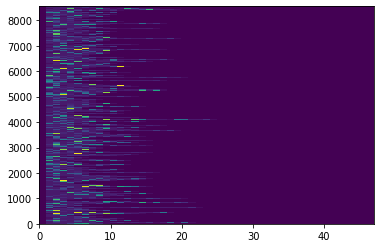

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
input_word_ids = tf.concat([cls, sentence], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

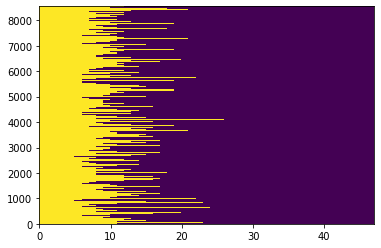

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

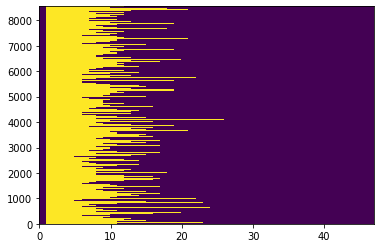

In [ ]:
type_cls = tf.zeros_like(cls)
type_s = tf.ones_like(sentence)
input_type_ids = tf.concat([type_cls, type_s], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence"])
  
  sentence = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence.shape[0]
  input_word_ids = tf.concat([cls, sentence], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s = tf.ones_like(sentence)

  input_type_ids = tf.concat(
      [type_cls, type_s], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

glue_train['input_type_ids'][10]

<tf.Tensor: shape=(47,), dtype=int32, numpy=
array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)>

In [ ]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (8551, 47)
input_mask      shape: (8551, 47)
input_type_ids  shape: (8551, 47)
glue_train_labels shape: (8551,)


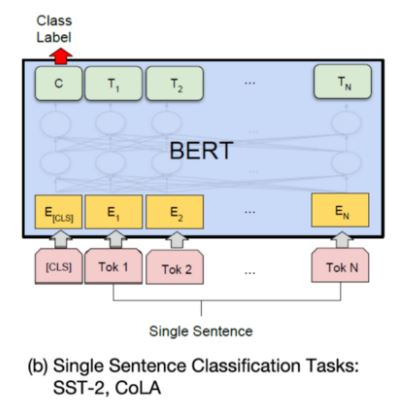

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers


**Model 1**

In [ ]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

Configuration for the model

In [ ]:
VOCAB_LENGTH = 30522
EMB_DIM = 768
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [ ]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [ ]:
text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])

In [ ]:
text_model.fit(glue_train['input_word_ids'], epochs=NB_EPOCHS)

Epoch 1/5


TypeError: ignored

We tried to adapt this model from https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/ which was implemented on IMDB dataset for text classication in sentiment analysis.

A class named TEXT_MODEL is inherited from the tf.keras.Model class. Inside the class the model layers are defined. Model consists of three convolutional neural network layers. This model was exclusively defined for IMDB dataset which was preprocessed and prepared for the model. 

We think our CoLA dataset isn't compatible with this model giving us the "NoneType" error.

**Model 2**

This is the model from the tutorial https://www.tensorflow.org/official_models/fine_tuning_bert adapted for CoLA dataset

There are three inputs to the model described as follows:

*   Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence. This binary encoded.
*   Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.
*Positional embeddings: A positional embedding is added to each token to indicate its position in the sentence.  This binary encoded.

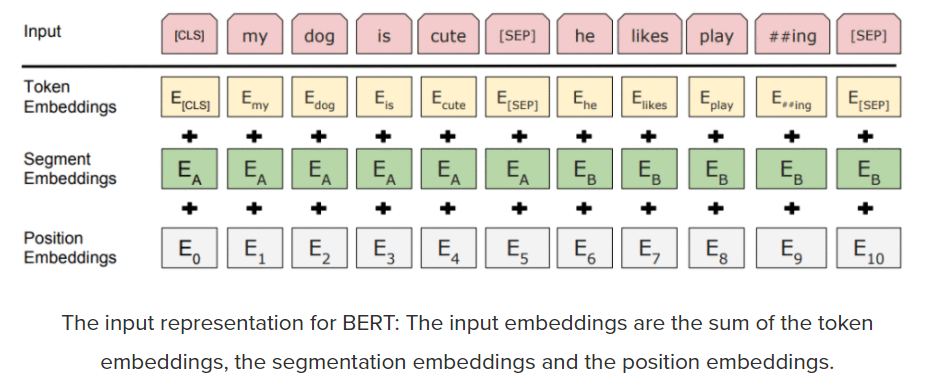

In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

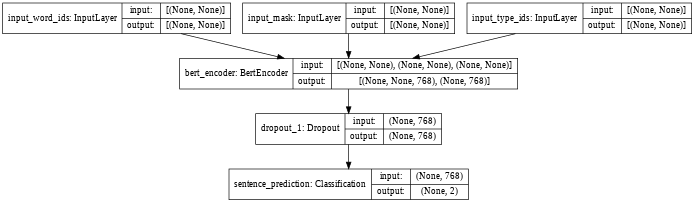

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [ ]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[ 0.17829879,  0.00936176],
       [ 0.36807287,  0.0379288 ],
       [ 0.2524935 ,  0.07789337],
       [ 0.30881298, -0.02353064],
       [ 0.28399017, -0.11770315],
       [ 0.13330951,  0.08240812],
       [ 0.2605341 ,  0.00602745],
       [ 0.28707123,  0.09117921],
       [ 0.22968788,  0.1468325 ],
       [ 0.32942477,  0.06139529]], dtype=float32)

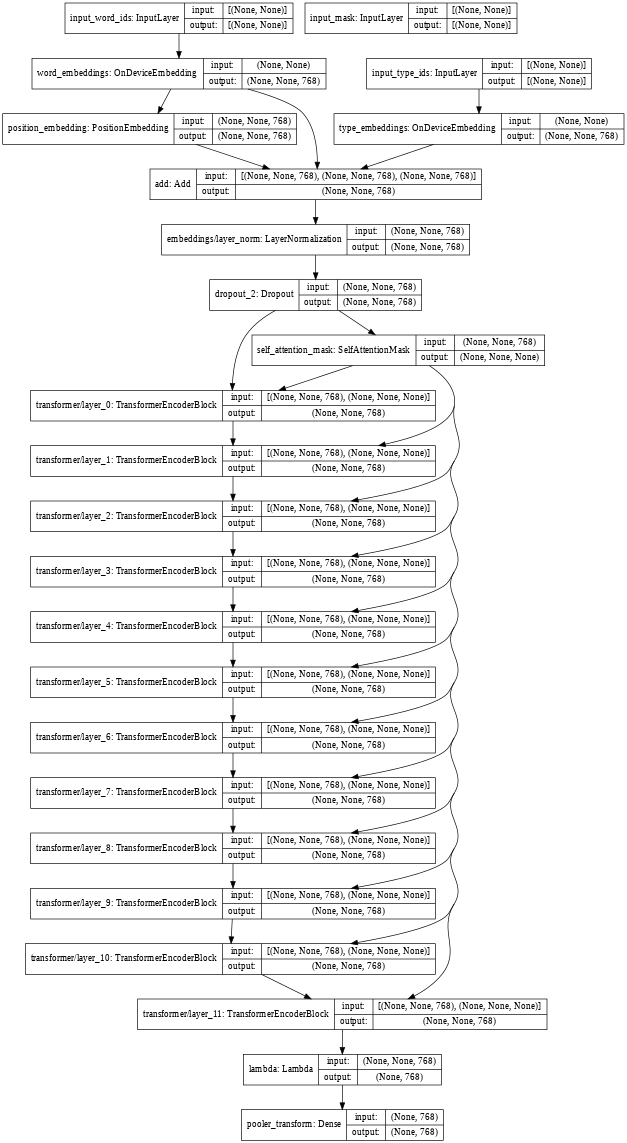

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [ ]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
# Set up epochs and steps
epochs = 1
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

268/268 [==============================] - 3794s 14s/step - loss: 0.5746 - accuracy: 0.7182 - val_loss: 0.4824 - val_accuracy: 0.7862


In [ ]:
my_examples = bert_encode(
    glue_dict = {
        'sentence':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.',
            'This is the third sentence example.',
            'This is the fourth sentence example.']
    },
    tokenizer=tokenizer)

In [ ]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

array([1, 0])

In [ ]:
np.array(info.features['label'].names)[result]

array(['acceptable', 'unacceptable'], dtype='<U12')



*   What is the tutorial classifying when using the GLUE MRPC data set?
Ans: The BERT tutorial is classifying if the two sentences are paraphrases of each other.
* In addition to the input itself, the tutorial feeds two binary tensors for input mask and input type to the model.
Is this necessary for the data set single sentence classification?
Ans: It doesn't really make sense for data set single sentence classification because the [SEP] token is used to identify the seperation between the two sentences, which is not the case in CoLA.
* How does the tokenization in BERT differ from the one in the previous Task 5?

* What is a [CLS] token and what is it used for? Which part of the BERT encoding is used for the classification?

Ans: CLS is used for classification. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output. On the output of the final (12th) transformer, only the first embedding (corresponding to the [CLS] token) is used by the classifier.

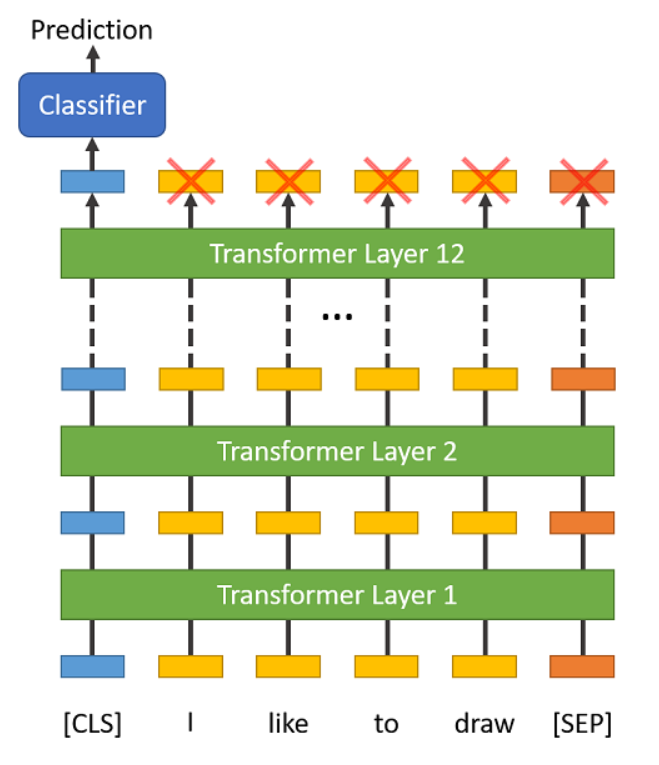



*Are the BERT encoder weights also fine-tuned to the task?
Ans: No, the weights are pre-trained which allows the task to be fine tuned on a smaller dataset.